<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Добавим-признаки." data-toc-modified-id="Добавим-признаки.-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Добавим признаки.</a></span></li><li><span><a href="#Линейная-регрессия." data-toc-modified-id="Линейная-регрессия.-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Линейная регрессия.</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>LightGBM</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li><li><span><a href="#GPU" data-toc-modified-id="GPU-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>GPU</a></span></li><li><span><a href="#задание-3" data-toc-modified-id="задание-3-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>задание 3</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

**Цель:**

Предсказывать количество заказов на час вперед для определения потребности необъодимого количества водителей. 

**Задача:**

Основное задачей проекта является подбор модели для предсказания.

**Проект состоит из следующих этапов:**
1. Подготовка данных.
2. Анализ.
3. Обучение.
4. Тестирование.

## Подготовка

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression


import lightgbm as lgb
import catboost

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from statsmodels.tsa.seasonal import seasonal_decompose

from time import time

In [2]:
TEST_SIZE = 0.1
RANDOM_STATE = 12345

In [3]:
try:
    taxi = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
    taxi.sort_index(inplace=True)
except:
    taxi = pd.read_csv(r"C:\Users\user1\Documents\Учеба Data science\Проекты спринтов\Численные методы\autos.csv")
    taxi.sort_index(inplace=True)

In [4]:
taxi.index.is_monotonic

True

In [5]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [6]:
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Проведем ресемплирование.

In [7]:
taxi = taxi.resample('1H').sum()

In [8]:
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Изучим временной отрезок

In [9]:
print(taxi.index.min())
print(taxi.index.max())

2018-03-01 00:00:00
2018-08-31 23:00:00


Вывод по загрузке данных:
- Загружен датасет в качестве временного ряда с шагом 10 минут. Проведено ресемплирование на `1H`
- всего значений в датасете 26тыс.
- Данные предоставлены за период с 1 марта по 31 августа 2018 года

## Анализ

In [10]:
taxi.isna().sum()

num_orders    0
dtype: int64

Пропусков нет.

In [11]:
taxi.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


Text(0.5, 1.0, 'Гистограмма целевого признака')

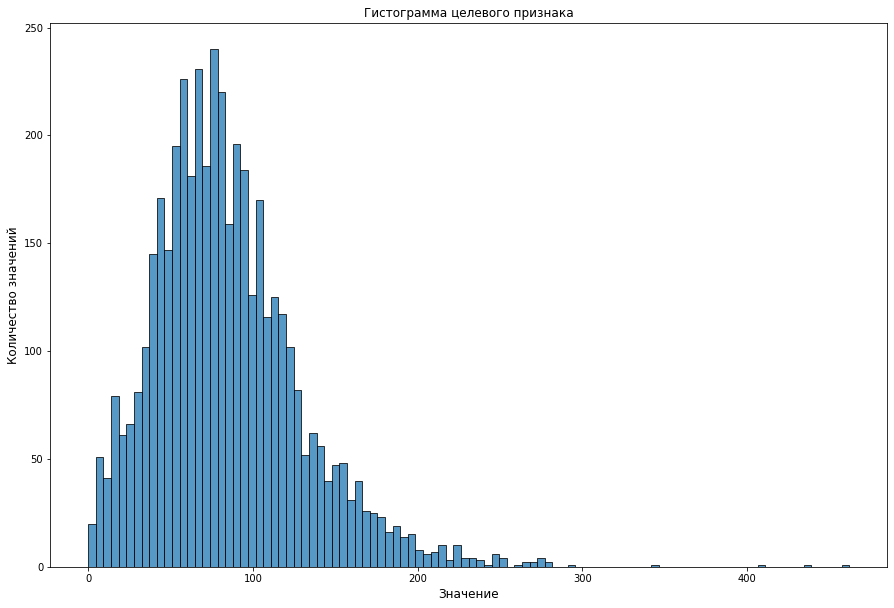

In [12]:
plt.figure(figsize=(15,10))
sns.histplot(data=taxi, legend=False, bins = 100)
plt.xlabel('Значение', fontsize='large')
plt.ylabel('Количество значений', fontsize='large')
plt.title('Гистограмма целевого признака')

Text(0.5, 1.0, 'Боксплот для целевого признака')

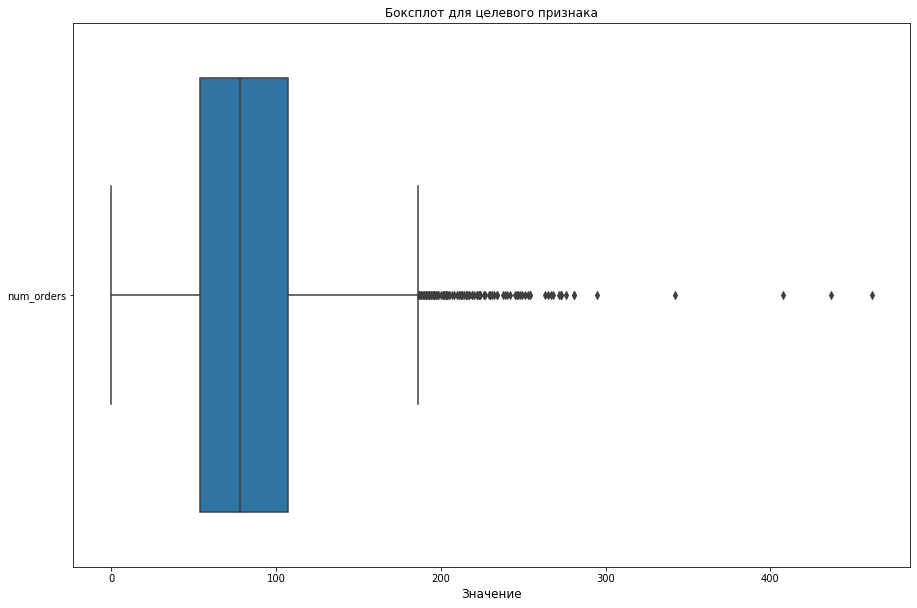

In [13]:
plt.figure(figsize=(15,10))
sns.boxplot(data=taxi, orient='h')
plt.xlabel('Значение', fontsize='large')
plt.title('Боксплот для целевого признака')

In [14]:
np.quantile(taxi,0.25)

54.0

In [15]:
np.quantile(taxi,0.75)

107.0

Text(0, 0.5, 'Количество заказов в день')

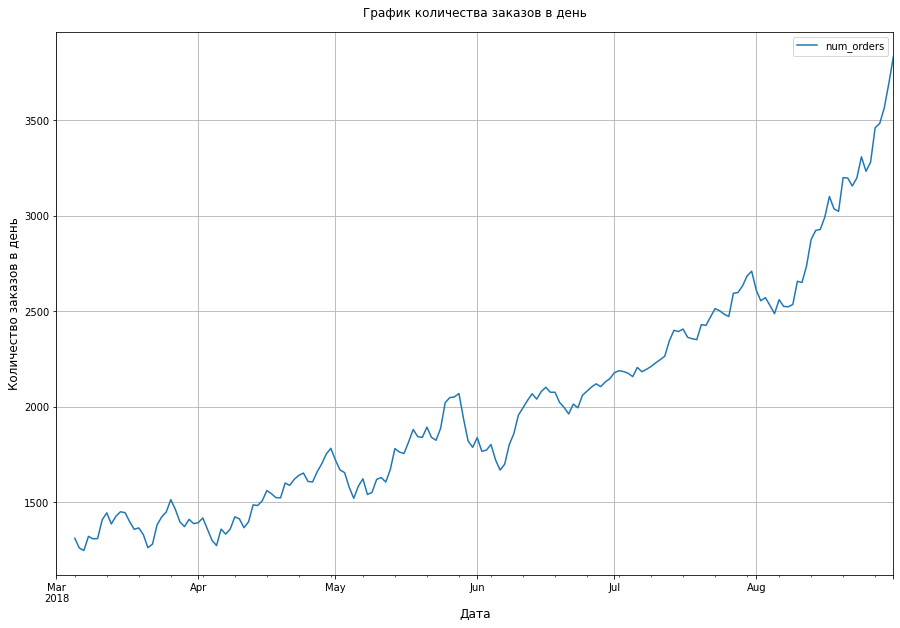

In [16]:
taxi.resample('1d').sum().rolling(5).mean().plot(figsize=(15,10), grid=True)
plt.title('График количества заказов в день', pad=15)
plt.xlabel('Дата', fontsize='large')
plt.ylabel('Количество заказов в день', fontsize='large')

Добавим столбцы.

In [17]:
taxi_copy = taxi.copy()

In [18]:
#taxi_copy['year'] = taxi.index.year
#taxi_copy['month'] = taxi.index.month
#taxi_copy['day_of_week'] = taxi.index.dayofweek
#taxi_copy['day'] = taxi.index.day

taxi_copy['day_of_week'] = taxi.index.dayofweek
taxi_copy['hour'] = taxi.index.hour


In [19]:
#taxi_copy.groupby('day_of_week')['num_orders'].mean().plot(figsize=(15,10), grid=True)
#plt.title('График количества заказов по дням недели', pad=15)
#plt.xlabel('Дата', fontsize='large')
#plt.ylabel('Количество заказов в день', fontsize='large')

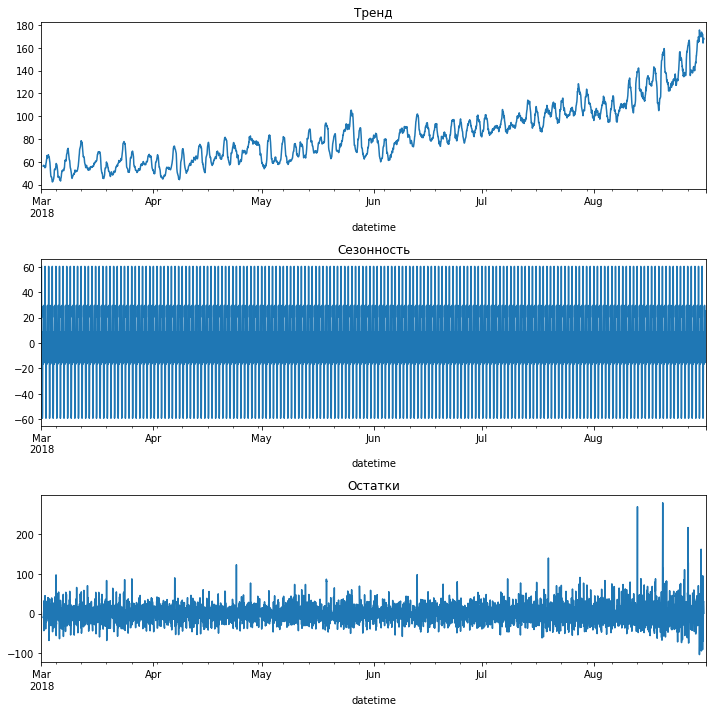

In [20]:
decomposed = seasonal_decompose(taxi)

plt.figure(figsize=(10, 10))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остатки')
plt.tight_layout()

Малоинформативно. Возьмем период в одну неделю в мае с 9 по 15 число.

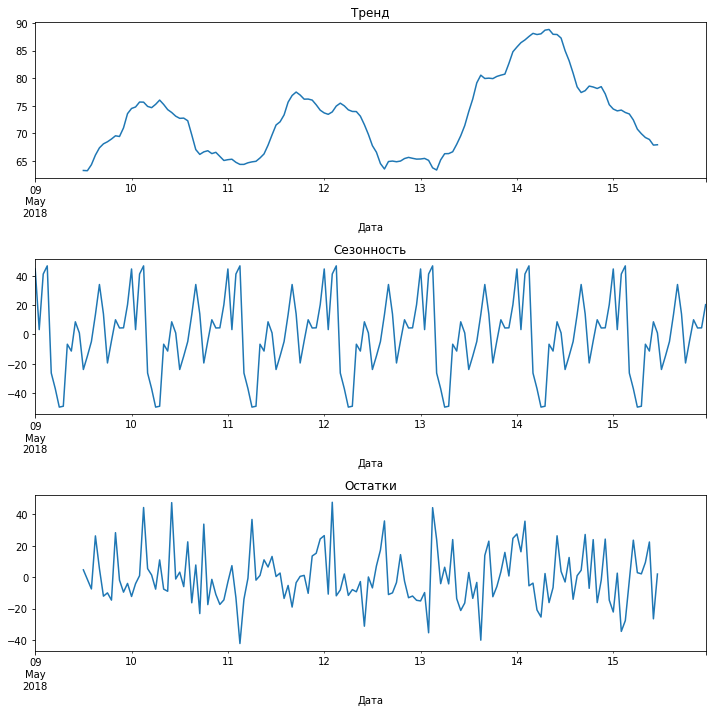

In [21]:
decomposed_week = seasonal_decompose(taxi['2018-05-09':'2018-05-15'])

plt.figure(figsize=(10, 10))
plt.subplot(311)

decomposed_week.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.xlabel('Дата')


plt.subplot(312)
decomposed_week.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.xlabel('Дата')


plt.subplot(313)
decomposed_week.resid.plot(ax=plt.gca())
plt.title('Остатки')
plt.xlabel('Дата')
plt.tight_layout()

**Выводы:**
- Среднее значение 84.42 заказов в час.
- максимум - 462, минимум - 0
- Распределение сдвинуто влево.
- Общий тренд растет, люди со временем больше пользуется такси.
- Утром количество заказов падает.
- Временной ряд в не является стационарным, так как тренд меняется.


## Обучение

### Добавим признаки.

Признаки год, месяц, день недели и номер дня уже есть. Создадим признаки с предыдущими значениями целевого признака.

In [22]:
def make_features_lag(data, column, max_lag, rolling_mean_size):
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data[column].shift(lag)

    data['rolling_mean'] = data[column].shift().rolling(rolling_mean_size).mean()

In [23]:
max_lag = 24
rolling_mean_size = 48

In [24]:
make_features_lag (taxi_copy, 'num_orders',max_lag, rolling_mean_size)

Создадим несколько моделей.

### Линейная регрессия.

In [25]:
train, test = train_test_split(taxi_copy, shuffle=False, test_size = TEST_SIZE, random_state = RANDOM_STATE)

In [26]:
train = train.dropna()

In [27]:
X_train = train.drop('num_orders', axis = 1)
y_train = train['num_orders']
X_test = test.drop('num_orders', axis = 1)
y_test = test['num_orders']


In [28]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3926, 27)
(442, 27)
(3926,)
(442,)


In [29]:
print(X_train.isna().sum().sum())
print(y_train.isna().sum())

0
0


In [30]:
X_train.index.is_monotonic

True

In [31]:
linear_model = LinearRegression()

In [32]:
linear_model.fit(X_train, y_train)

LinearRegression()

### CatBoost

In [33]:
catboost_model = CatBoostRegressor(verbose=False,
                                   random_state=RANDOM_STATE)

In [34]:
tscv = TimeSeriesSplit(n_splits=3) 

In [35]:
param_grid = {
    'depth' : [1,3,5],
    'learning_rate' : [0.1, 0.3],
    'iterations' : [100, 200, 300]
             }

grid_search_catboost = GridSearchCV (
    catboost_model, 
    param_grid, 
    scoring='neg_root_mean_squared_error', 
    cv=tscv
)

time_start = time()

grid_search_catboost.fit(X_train, y_train)

time_finish = time()

duration = round(time_finish - time_start)
print('Время работы GridSearch ', duration)

Время работы GridSearch  55


In [36]:
print(grid_search_catboost.best_params_)

{'depth': 5, 'iterations': 300, 'learning_rate': 0.1}


In [37]:
catboost_model = CatBoostRegressor(verbose=False,
                                   random_state=RANDOM_STATE, depth = 5, iterations = 300, learning_rate = 0.1)

In [38]:
catboost_model.fit(X_train, y_train)

In [39]:
catboost_model.best_score_

{'learn': {'RMSE': 15.81776914383755}}

Для CatBoost метрика RMSE при кросс валидации составила 15.82

### LightGBM

In [40]:
LGBMR = LGBMRegressor(verbose=10, random_state=RANDOM_STATE)

In [41]:
param_grid = {
    'max_depth' : [3],
    'learning_rate' : [0.1],
    }

random_search_lgbm = RandomizedSearchCV (
    LGBMR, 
    param_grid, 
    scoring='neg_root_mean_squared_error', 
    cv=tscv,
    n_iter = 3
)

time_start = time()

random_search_lgbm.fit(X_train, y_train)

time_finish = time()

duration = round(time_finish - time_start)
print('Время работы RandomizedSearch ', duration)

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=3. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.007875
[LightGBM] [Debug] init for col-wise cost 0.000010 seconds, init for row-wise cost 0.000850 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000987 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3021
[LightGBM] [Info] Number of data points in the train set: 983, number of used features: 27
[LightGBM] [Info] Start training from score 57.155646
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 7 and depth = 3
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 3
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 3
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 3
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 7 and depth = 3
[LightGBM

In [42]:
random_search_lgbm.best_params_

{'max_depth': 3, 'learning_rate': 0.1}

In [43]:
LGBMR = LGBMRegressor(verbose=10, random_state=RANDOM_STATE, max_depth = 3, learning_rate = 0.1)

In [44]:
LGBMR.fit(X_train, y_train)

[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.007113
[LightGBM] [Debug] init for col-wise cost 0.000008 seconds, init for row-wise cost 0.000941 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000563 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 4836
[LightGBM] [Info] Number of data points in the train set: 3926, number of used features: 27
[LightGBM] [Info] Start training from score 78.516811
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 3
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 3
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 3
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 3
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 3
[LightGBM] [Debug] Trained a tree with leaves = 8

LGBMRegressor(max_depth=3, random_state=12345, verbose=10)

## Тестирование

Отберем модель по результатам кросс валидации.

In [45]:
linear_model_cv = cross_val_score(linear_model, X_train, y_train, cv=tscv, scoring = 'neg_root_mean_squared_error').mean()*(-1)

In [46]:
catboost_cv = cross_val_score(catboost_model, X_train, y_train, cv=tscv, scoring = 'neg_root_mean_squared_error').mean()*(-1)

In [47]:
LGBMR_cv = cross_val_score(LGBMR, X_train, y_train, cv=tscv, scoring = 'neg_root_mean_squared_error').mean()*(-1)

[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.007875
[LightGBM] [Debug] init for col-wise cost 0.000711 seconds, init for row-wise cost 0.000873 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001093 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 3021
[LightGBM] [Info] Number of data points in the train set: 983, number of used features: 27
[LightGBM] [Info] Start training from score 57.155646
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 7 and depth = 3
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 3
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 3
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 3
[LightGBM] [Warning] No further splits 

In [48]:
model = ['linear', 'catboost', 'lgbm']
metrics_cv = [linear_model_cv, catboost_cv, LGBMR_cv]

In [49]:
table_2 = pd.DataFrame({'model':model, 'cross_val_score': metrics_cv})
table_2

,model,cross_val_score
0,linear,28.236083
1,catboost,25.919805
2,lgbm,26.616247


Text(0.5, 0, 'Название модели')

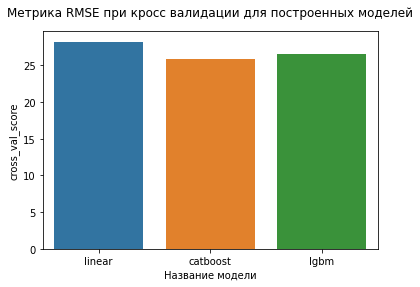

In [50]:
sns.barplot(data = table_2, x='model', y = 'cross_val_score')
plt.title('Метрика RMSE при кросс валидации для построенных моделей', fontsize='large', pad =15)
plt.xlabel('Название модели')

По результатам сравнения моделей методом кросс валидации выбрана модель CatBoost.

Посмотрим на результат работы модели на тестовой выборке.

In [51]:
catboost_rmse_test = mean_squared_error(y_test, catboost_model.predict(X_test), squared=False)
catboost_rmse_test

41.1340707845367

Метрика RMSE составила 41.73 - соответствует условию.

**Выводы:**

В данной работе были выполнены следующие этапы:
1. Проведена загрузка данных о количестве заказов такси из 26 тыс. значений с шагом 10 мин. Ресемплировано на один час.
2. Исследовательский анализ. Построены графики и выявлен тренд на возрастание количества заказов.
3. Для решения задачи регрессии построены три модели: одна линейная и две модели градиентного бустинга: CatBoost и LightGBM.
4. Методом кросс валидации проведена оценка работы моделей. Лучшей моделью по метрике RMSE выбрана CatBoost. Значение метрики составило 41.73 - соответствует условию.

**Рекомендация Заказчику:**

Для выполнения задачи предсказания количества заказов рекомендуется использовать обученную в данном проекте модель CatBoost.



## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48